# Exogenous variables

Exogenous variables or external factors are crucial in time series forecasting as they provide additional information that might influence the prediction. These variables could include holiday markers, marketing spending, weather data, or any other external data that correlate with the time series data you are forecasting.

For example, if you're forecasting ice cream sales, temperature data could serve as a useful exogenous variable. On hotter days, ice cream sales may increase.

To incorporate exogenous variables in TimeGEN, you'll need to pair each point in your time series data with the corresponding external data.

To complete this tutorial, you will need to:

* Install `nixtla` and `pandas`:

    ```bash
    pip install nixtla pandas
    ```

## 1. Import packages
First, we import the required packages and initialize the Nixtla client.

In [ ]:
import pandas as pd
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    base_url="you azure ai endpoint", 
    api_key="your api_key",
)

## 2. Load data

Let's see an example on predicting day-ahead electricity prices. The following dataset contains the hourly electricity price (`y` column) for five markets in Europe and US, identified by the `unique_id` column. The columns from `Exogenous1` to `day_6` are exogenous variables that TimeGEN will use to predict the prices.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df.head()

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-10-22 00:00:00,70.00,49593.0,57253.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-10-22 01:00:00,37.10,46073.0,51887.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-10-22 02:00:00,37.10,44927.0,51896.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-10-22 03:00:00,44.75,44483.0,48428.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-10-22 04:00:00,37.10,44338.0,46721.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Forecasting electricity prices using exogenous variables

To produce forecasts we also have to add the future values of the exogenous variables. Let's read this dataset. In this case, we want to predict 24 steps ahead, therefore each `unique_id` will have 24 observations.

::: {.callout-important}
If you want to use exogenous variables when forecasting with TimeGEN, you need to have the future values of those exogenous variables too.
::: 

In [ ]:
future_ex_vars_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-future-ex-vars.csv')
future_ex_vars_df.head()

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,64108.0,70318.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,62492.0,67898.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,61571.0,68379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,60381.0,64972.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,60298.0,62900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Let's call the `forecast` method, adding this information:

In [ ]:
fcst_ex_vars_df = nixtla_client.forecast(df=df, X_df=future_ex_vars_df, h=24, level=[80, 90])
fcst_ex_vars_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,BE,2016-12-31 00:00:00,73.493142,70.078520,71.392108,75.594176,76.907764
1,BE,2016-12-31 01:00:00,40.662639,31.936856,33.943513,47.381765,49.388423
2,BE,2016-12-31 02:00:00,41.914824,34.562498,38.630084,45.199563,49.267149
3,BE,2016-12-31 03:00:00,35.943631,28.171378,32.854032,39.033229,43.715884
4,BE,2016-12-31 04:00:00,35.952568,29.003433,31.987409,39.917728,42.901703


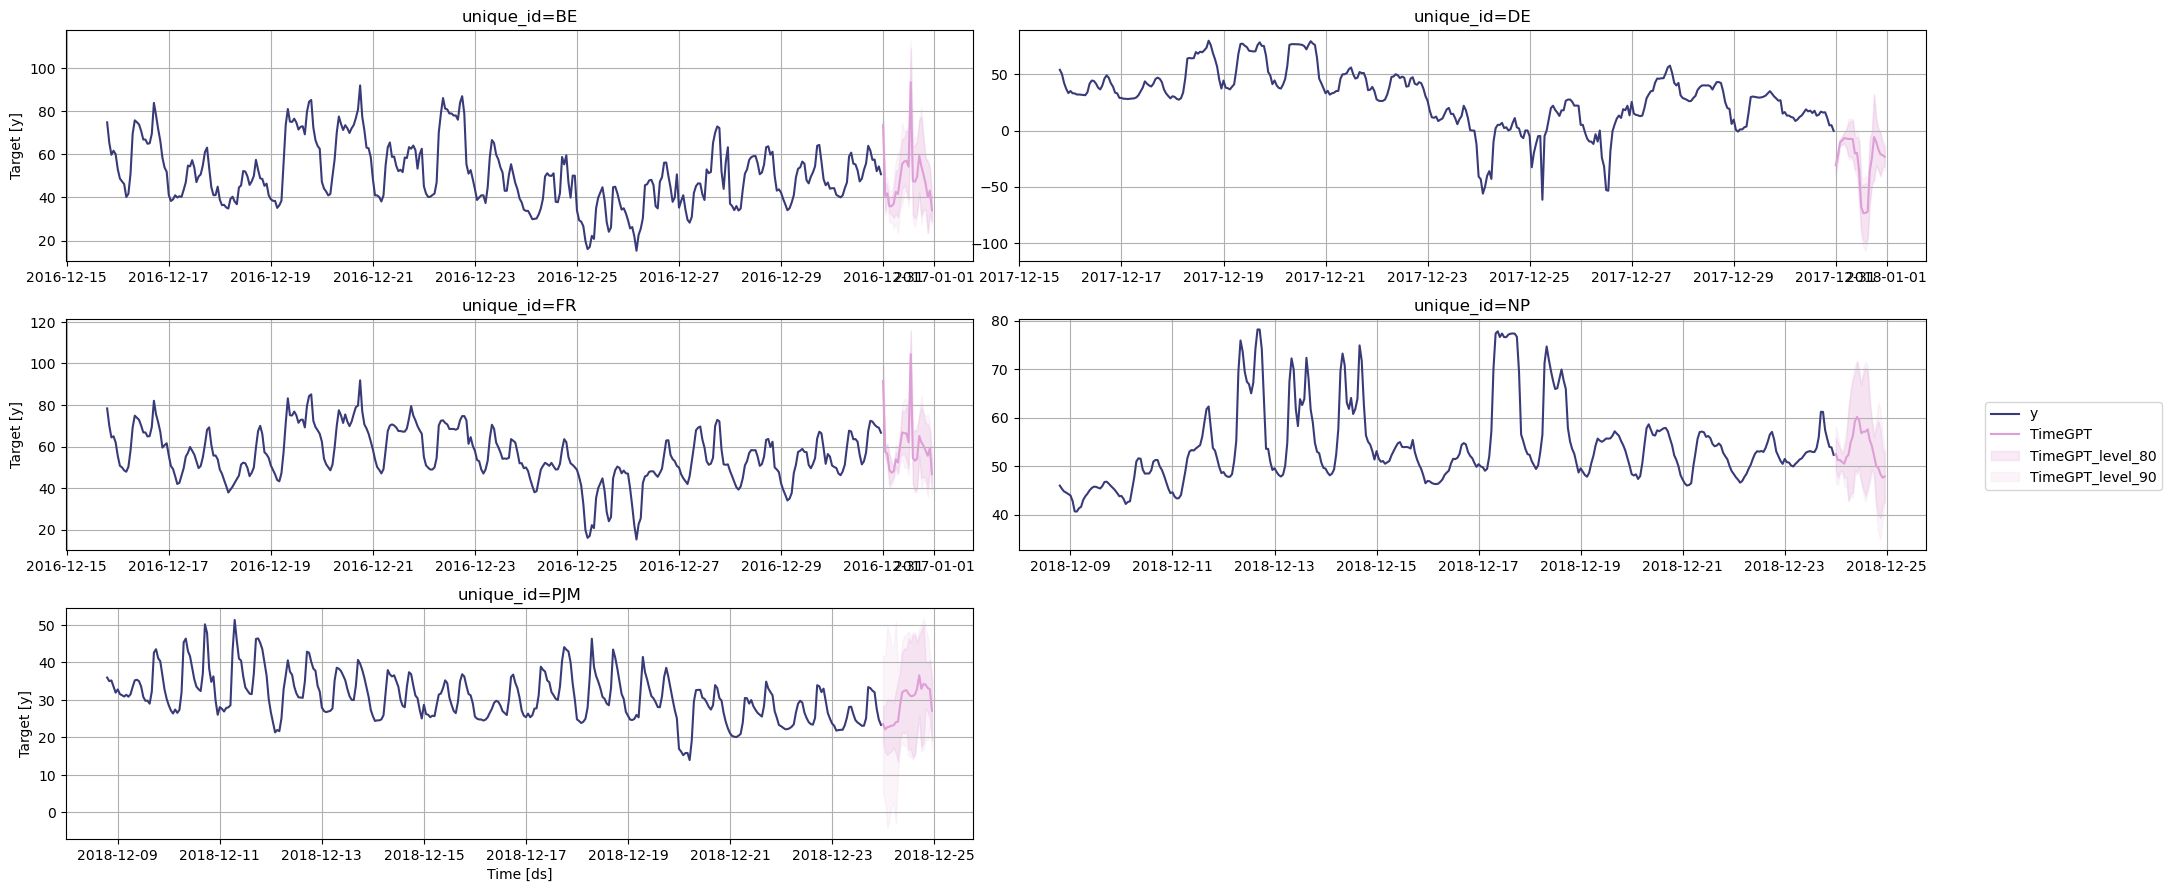

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    fcst_ex_vars_df, 
    max_insample_length=365, 
    level=[80, 90], 
)

We can also show the importance of the features.

<Axes: ylabel='features'>

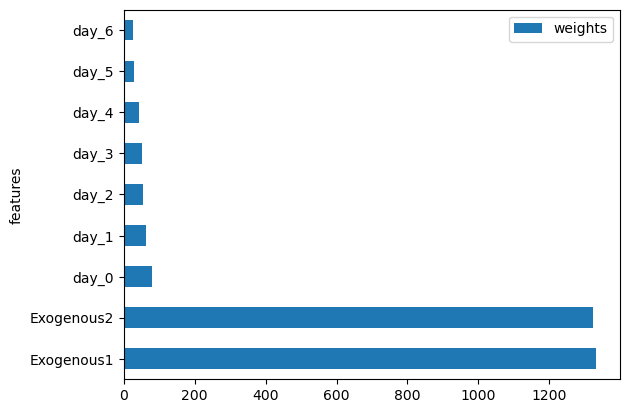

In [ ]:
nixtla_client.weights_x.plot.barh(x='features', y='weights')

This plot shows that `Exogenous1` and `Exogenous2` are the most important for this forecasting task, as they have the largest weight.

## 4. How to generate future exogenous variables?

In the example above, we just loaded the future exogenous variables. Often, these are not available because these variables are unknown. Hence, we need to forecast these too. 

::: {.callout-important}
If you would only include historic exogenous variables in your model, you would be _implicitly_ making assumptions about the future of these exogenous variables in your forecast. That's why TimeGEN requires you to explicitly incorporate the future of these exogenous variables too, so that you make your assumptions about these variables _explicit_.
::: 

Below, we'll show you how we can also forecast `Exogenous1` and `Exogenous2` separately, so that you can generate the future exogenous variables in case they are not available.

In [ ]:
# We read the data and create separate dataframes for the historic exogenous that we want to forecast separately.
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df_exog1 = df[['unique_id', 'ds', 'Exogenous1']]
df_exog2 = df[['unique_id', 'ds', 'Exogenous2']]

Next, we can use TimeGEN to forecast `Exogenous1` and `Exogenous2`. In this case, we assume these quantities can be separately forecast.

In [ ]:
fcst_ex1 = nixtla_client.forecast(df=df_exog1, h=24, target_col='Exogenous1')
fcst_ex2 = nixtla_client.forecast(df=df_exog2, h=24, target_col='Exogenous2')

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


We can now start creating `X_df`, which contains the future exogenous variables.

In [ ]:
fcst_ex1 = fcst_ex1.rename(columns={'TimeGPT':'Exogenous1'})
fcst_ex2 = fcst_ex2.rename(columns={'TimeGPT':'Exogenous2'})

In [ ]:
X_df = fcst_ex1.merge(fcst_ex2)

Next, we also need to add the `day_0` to `day_6` future exogenous variables. These are easy: this is just the weekday, which we can extract from the `ds` column.

In [ ]:
# We have 7 days, for each day a separate column denoting 1/0
for i in range(7):
    X_df[f'day_{i}'] = 1 * (pd.to_datetime(X_df['ds']).dt.weekday == i)
    

We have now created `X_df`, let's investigate it:

In [ ]:
X_df.head(10)

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,65146.140625,70953.921875,0,0,0,0,0,1,0
1,BE,2016-12-31 01:00:00,62354.484375,67220.250000,0,0,0,0,0,1,0
2,BE,2016-12-31 02:00:00,60710.343750,65833.750000,0,0,0,0,0,1,0
3,BE,2016-12-31 03:00:00,59259.269531,63106.718750,0,0,0,0,0,1,0
4,BE,2016-12-31 04:00:00,58496.394531,61042.417969,0,0,0,0,0,1,0
5,BE,2016-12-31 05:00:00,58281.121094,60848.796875,0,0,0,0,0,1,0
6,BE,2016-12-31 06:00:00,58238.140625,60561.683594,0,0,0,0,0,1,0
7,BE,2016-12-31 07:00:00,59485.113281,62289.953125,0,0,0,0,0,1,0
8,BE,2016-12-31 08:00:00,60752.492188,64499.515625,0,0,0,0,0,1,0
9,BE,2016-12-31 09:00:00,61726.292969,65948.195312,0,0,0,0,0,1,0


Let's compare it to our pre-loaded version:

In [ ]:
future_ex_vars_df.head(10)

,unique_id,ds,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-31 00:00:00,64108.0,70318.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,BE,2016-12-31 01:00:00,62492.0,67898.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,BE,2016-12-31 02:00:00,61571.0,68379.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,BE,2016-12-31 03:00:00,60381.0,64972.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,BE,2016-12-31 04:00:00,60298.0,62900.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,BE,2016-12-31 05:00:00,60339.0,62364.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,BE,2016-12-31 06:00:00,62576.0,64242.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,BE,2016-12-31 07:00:00,63732.0,65884.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,BE,2016-12-31 08:00:00,66235.0,68217.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,BE,2016-12-31 09:00:00,66801.0,69921.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


As you can see, the values for `Exogenous1` and `Exogenous2` are slightly different, which makes sense because we've made a forecast of these values with TimeGEN.

Let's create a new forecast of our electricity prices with TimeGEN using our new `X_df`:

In [ ]:
fcst_ex_vars_df_new = nixtla_client.forecast(df=df, X_df=X_df, h=24, level=[80, 90])
fcst_ex_vars_df_new.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: H
INFO:nixtla.nixtla_client:Using the following exogenous variables: Exogenous1, Exogenous2, day_0, day_1, day_2, day_3, day_4, day_5, day_6
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,unique_id,ds,TimeGPT,TimeGPT-lo-90,TimeGPT-lo-80,TimeGPT-hi-80,TimeGPT-hi-90
0,BE,2016-12-31 00:00:00,58.335332,54.920710,56.234298,60.436367,61.749954
1,BE,2016-12-31 01:00:00,38.894719,30.168935,32.175593,45.613844,47.620502
2,BE,2016-12-31 02:00:00,38.840619,31.488293,35.555879,42.125358,46.192944
3,BE,2016-12-31 03:00:00,35.760249,27.987996,32.670651,38.849848,43.532502
4,BE,2016-12-31 04:00:00,36.823794,29.874659,32.858635,40.788954,43.772929


Let's create a combined dataframe with the two forecasts and plot the values to compare the forecasts.

In [ ]:
fcst_ex_vars_df = fcst_ex_vars_df.rename(columns={'TimeGPT':'TimeGPT-provided_exogenous'})
fcst_ex_vars_df_new = fcst_ex_vars_df_new.rename(columns={'TimeGPT':'TimeGPT-forecasted_exogenous'})

forecasts = fcst_ex_vars_df[['unique_id', 'ds', 'TimeGPT-provided_exogenous']].merge(fcst_ex_vars_df_new[['unique_id', 'ds', 'TimeGPT-forecasted_exogenous']])

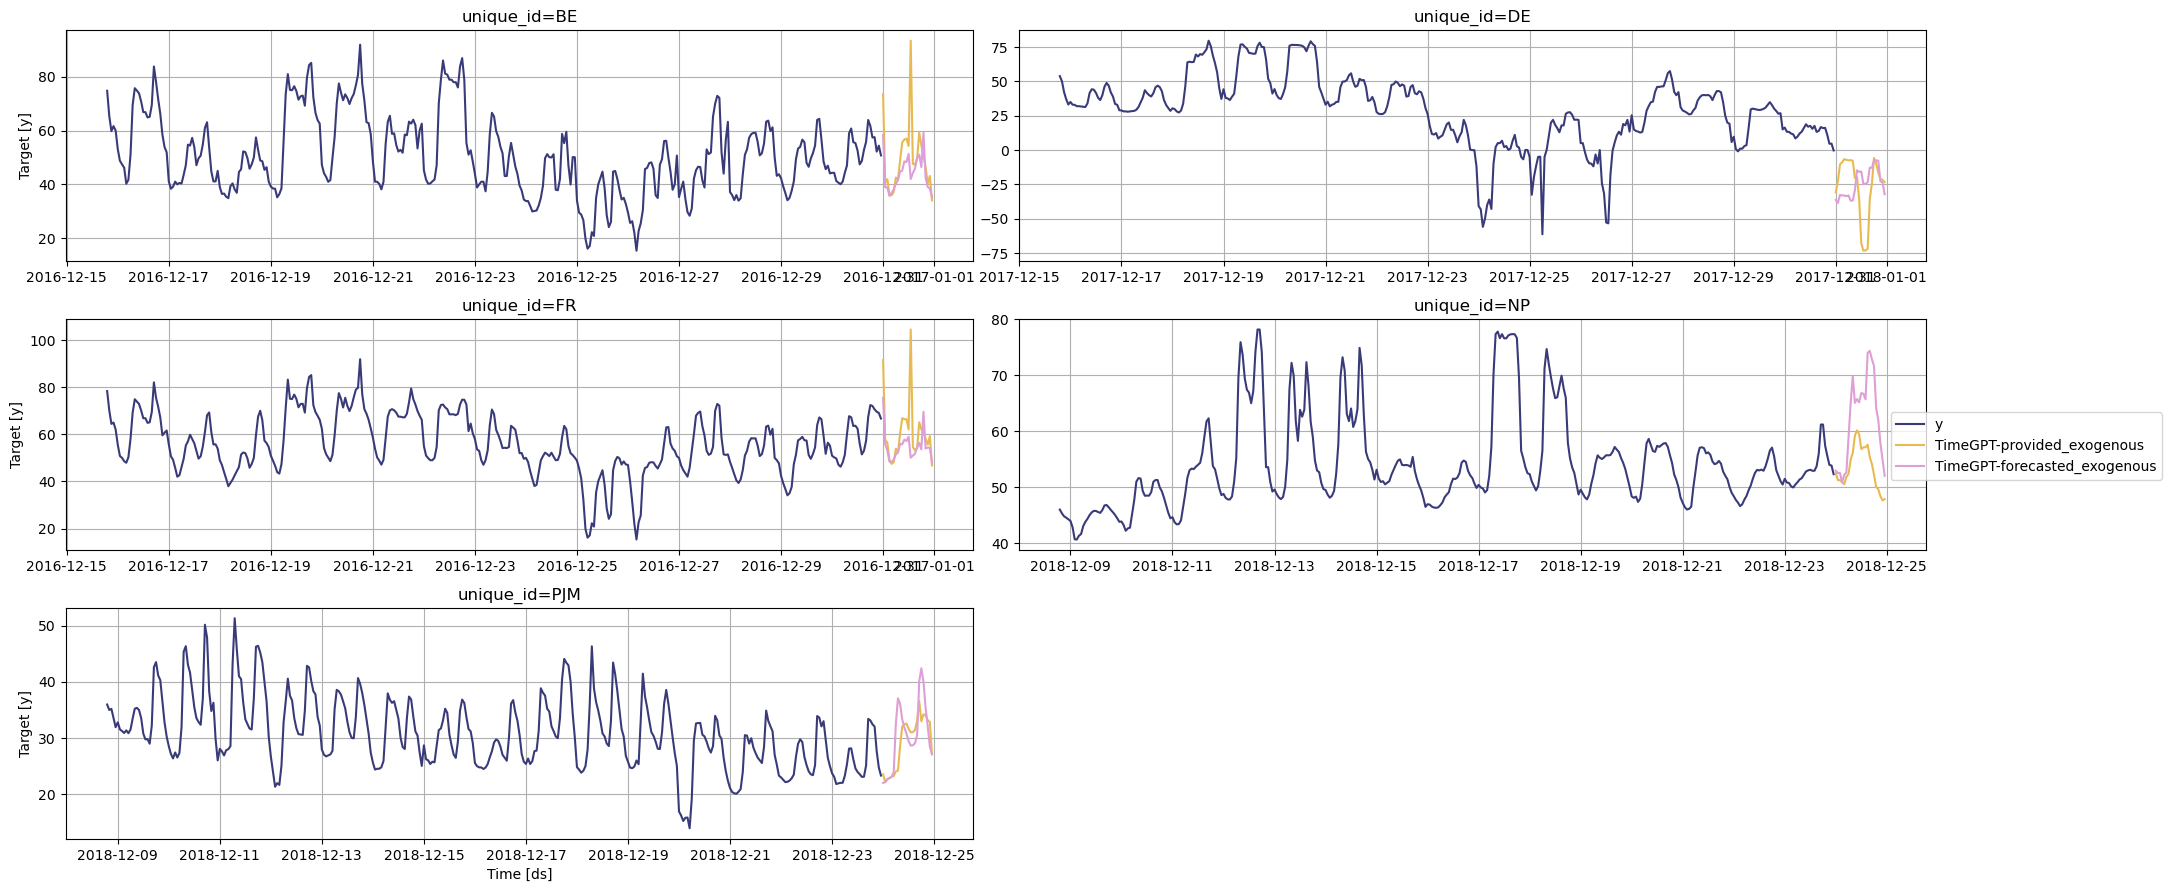

In [ ]:
nixtla_client.plot(
    df[['unique_id', 'ds', 'y']], 
    forecasts, 
    max_insample_length=365, 
)

As you can see, we obtain a slightly different forecast if we use our forecasted exogenous variables. 